In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
#EDA
# CSV dosyasından veriyi okuma 
df = pd.read_csv(r"C:\Users\sedra\Downloads\XAU_15m_data_2004_to_2024-20-09.csv.zip")

# Verinin boyutunu gösterme
print("\n Verinin boyutu (satır × sütun):")
print(df.shape) 

# İlk 5 satırı gösterme
print("\n Verinin ilk 5 satırı:")
display(df.head())

# Tarih sütununu datetime tipine çevirme
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Veriyi tarih sırasına göre sıralama
df = df.sort_values(by="Date")

# Eksik değerler
print("\n Eksik değer sayısı:")
display(df.isnull().sum())



 Verinin boyutu (satır × sütun):
(464737, 7)

 Verinin ilk 5 satırı:


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20



 Eksik değer sayısı:


Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [3]:
#VERİLERİNİ TEMİZLEME
# verisinde eksik değer var mı yok mı kontrol edelim
print("\n Temizlik öncesi eksik değerler:")
print(df.isnull().sum())

# Sayısal sütunlarda eksik değer varsa → ortalama ile doldur
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

# Tarih sütununda eksik varsa → satırı sil
if 'Date' in df.columns:
    df = df.dropna(subset=['Date'])

print("\n Eksik değerler işlendi.")

#Aykırı Değer Tespiti (IQR Yöntemi) 
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f" {col}: Aykırı değer sayısı = {len(outliers)}")




 Temizlik öncesi eksik değerler:
Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

 Eksik değerler işlendi.
 Open: Aykırı değer sayısı = 0
 High: Aykırı değer sayısı = 0
 Low: Aykırı değer sayısı = 0
 Close: Aykırı değer sayısı = 0
 Volume: Aykırı değer sayısı = 24330


In [4]:
# FEATURE ENGINEERING (GELİŞTİRİLMİŞ)

# Datetime oluşturma (Date + Time sütunları varsa)

if 'Time' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'])
else:
    df['Datetime'] = df['Date']

# Veriyi zaman sırasına göre sıralama
df = df.sort_values('Datetime').reset_index(drop=True)

# Önceki kapanış fiyatı ile aynıysa tekrar eden satırları kaldırma
df = df[df['Close'].diff() != 0].reset_index(drop=True)

# Zaman özellikleri ekleme
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Weekday'] = df['Datetime'].dt.weekday  # 0 = Pazartesi, 6 = Pazar

# Temel fiyat farkları
df['High_Low_Diff'] = df['High'] - df['Low']
df['Close_Open_Diff'] = df['Close'] - df['Open']
df['High_Close_Diff'] = df['High'] - df['Close']
df['Low_Close_Diff'] = df['Low'] - df['Close']

# Rolling / Moving Average ve STD (son 3, 5, 10 periyotlar için)
for w in [3,5,10]:
    df[f'MA_Close_{w}'] = df['Close'].rolling(window=w).mean()
    df[f'STD_Close_{w}'] = df['Close'].rolling(window=w).std()
    df[f'MA_High_{w}'] = df['High'].rolling(window=w).mean()
    df[f'MA_Low_{w}'] = df['Low'].rolling(window=w).mean()

# Fiyatın önceki kapanış ile farkı (lag features)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Momentum özelliği
df['Momentum_1'] = df['Close'] - df['Close_Lag1']
df['Momentum_2'] = df['Close'] - df['Close_Lag2']





In [5]:
# İlk 10 satırı göster
print("\n Geliştirilmiş Feature Engineering sonrası veri:")
display(df.head(10))


 Geliştirilmiş Feature Engineering sonrası veri:


,Date,Time,Open,High,Low,Close,Volume,Datetime,Year,Month,...,MA_Low_5,MA_Close_10,STD_Close_10,MA_High_10,MA_Low_10,Close_Lag1,Close_Lag2,Close_Lag3,Momentum_1,Momentum_2
0,2004-06-11,07:15,384.0,384.3,383.8,384.3,12,2004-06-11 07:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-06-11,07:30,383.8,384.3,383.6,383.8,12,2004-06-11 07:30:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,384.3,NaN,NaN,-0.5,NaN
2,2004-06-11,08:00,383.8,384.1,383.6,383.6,8,2004-06-11 08:00:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.8,384.3,NaN,-0.2,-0.7
3,2004-06-11,08:15,383.6,384.3,383.5,383.5,20,2004-06-11 08:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.6,383.8,384.3,-0.1,-0.3
4,2004-06-11,08:45,383.3,383.3,383.1,383.1,6,2004-06-11 08:45:00,2004,6,...,383.52,NaN,NaN,NaN,NaN,383.5,383.6,383.8,-0.4,-0.5
5,2004-06-11,09:00,383.1,384.1,383.1,383.6,9,2004-06-11 09:00:00,2004,6,...,383.38,NaN,NaN,NaN,NaN,383.1,383.5,383.6,0.5,0.1
6,2004-06-11,09:15,383.8,384.0,382.8,383.0,15,2004-06-11 09:15:00,2004,6,...,383.22,NaN,NaN,NaN,NaN,383.6,383.1,383.5,-0.6,-0.1
7,2004-06-11,09:45,383.0,383.3,382.8,383.1,11,2004-06-11 09:45:00,2004,6,...,383.06,NaN,NaN,NaN,NaN,383.0,383.6,383.1,0.1,-0.5
8,2004-06-11,10:00,383.0,383.6,383.0,383.6,10,2004-06-11 10:00:00,2004,6,...,382.96,NaN,NaN,NaN,NaN,383.1,383.0,383.6,0.5,0.6
9,2004-06-11,12:45,383.8,383.8,383.3,383.3,4,2004-06-11 12:45:00,2004,6,...,383.00,383.49,0.390014,383.91,383.26,383.6,383.1,383.0,-0.3,0.2


Altın Fiyatı Zaman Serisi Görselleştirmesi:


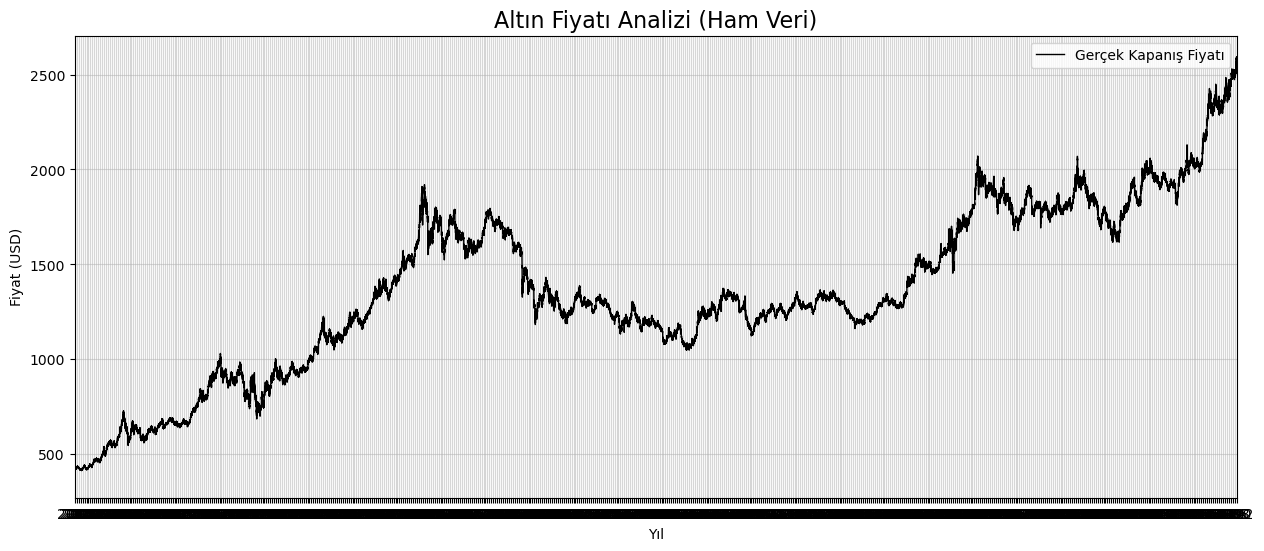

In [27]:
#Veri analiz
import matplotlib.dates as mdates

print("Altın Fiyatı Zaman Serisi Görselleştirmesi:")

plt.figure(figsize=(15, 6))
# Tüm zaman serisini çiziyoru
plt.plot(df.index, df['Close'], color='black', linewidth=1, label='Gerçek Kapanış Fiyatı')

# X eksenini daha okunaklı yapmak için 2 yıllık aralıklarla etiketleme
plt.xlim(pd.Timestamp('2004-01-01'), df.index.max()) # Belirli bir başlangıçtan en sona kadar
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Altın Fiyatı Analizi (Ham Veri)", fontsize=16)
plt.xlabel("Yıl")
plt.ylabel("Fiyat (USD)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

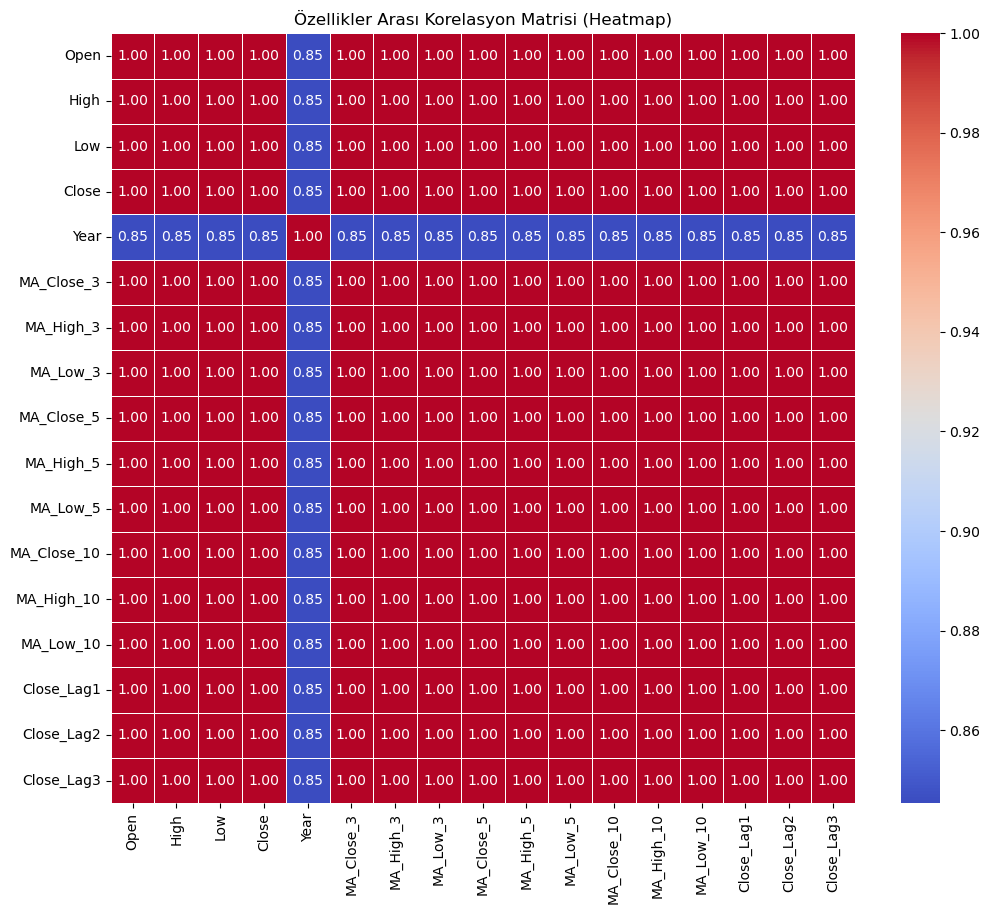

In [24]:
#Korelasyon matrisi
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece sayısal sütunları alalım
numerical_df = df.select_dtypes(include=[np.number])

# Korelasyon hesapla
corr_matrix = numerical_df.corr()

# Hedef değişken (Close) ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix.index[abs(corr_matrix["Close"]) > 0.5]

plt.figure(figsize=(12, 10))
plt.title("Özellikler Arası Korelasyon Matrisi (Heatmap)")
# Sadece en ilişkili özellikleri çizelim ki grafik karışmasın
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [6]:
# 1) Sayısal olmayan sütunların kaldırılması (ör. Timestamp)
X = df.drop("Close", axis=1)  # hedef sütun hariç tüm sütunlar
y = df["Close"]               # tahmin etmek istediğimiz sütun

X = X.select_dtypes(include=['float64', 'int64'])

# 2) %80 - %20 bölme, karıştırma olmadan
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# 3) Ölçeklendirme (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train:", X_train_scaled.shape)
print("X_test:", X_test_scaled.shape)


X_train: (357284, 25)
X_test: (89322, 25)


In [7]:
# Sadece sayısal sütunları tutma
X_train_df = X_train.select_dtypes(include=[np.number])
X_test_df = X_test[X_train_df.columns]  # Aynı sütunlar

# NaN değerlerin ortalama ile doldurulması
X_train_df = X_train_df.fillna(X_train_df.mean())
X_test_df = X_test_df.fillna(X_train_df.mean())  # Aynı ortalama kullanıldı

# Mutual Information hesaplama
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_train_df, y_train, random_state=42)

# Özellikleri önem sırasına göre sıralama
mi_scores_series = pd.Series(mi_scores, index=X_train_df.columns).sort_values(ascending=False)

# En iyi 10 özelliği seçme
selected_features = mi_scores_series.head(10).index.tolist()

print("\n Mutual Information ile en iyi 10 özellik:")
for f in selected_features:
    print("→", f)

# Sadece seçilen özelliklerle yeni X oluşturma
X_train_selected = X_train_df[selected_features].values
X_test_selected = X_test_df[selected_features].values

print("\nMutual Information sonrası yeni X boyutları:")
print("X_train_selected:", X_train_selected.shape)
print("X_test_selected:", X_test_selected.shape)



 Mutual Information ile en iyi 10 özellik:
→ High
→ Low
→ MA_Close_3
→ Open
→ Close_Lag1
→ MA_High_3
→ MA_Low_3
→ MA_Close_5
→ MA_High_5
→ MA_Low_5

Mutual Information sonrası yeni X boyutları:
X_train_selected: (357284, 10)
X_test_selected: (89322, 10)


In [8]:
from sklearn.decomposition import PCA

# PCA uygulama ve varyansın %95'ini koruma
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print("\n PCA sonrası veriler model için hazır:")
print(f"X_train_pca: {X_train_pca.shape}, X_test_pca: {X_test_pca.shape}")



 PCA sonrası veriler model için hazır:
X_train_pca: (357284, 1), X_test_pca: (89322, 1)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modeli oluşturma
linear_model = LinearRegression()

# Modeli eğitme
linear_model.fit(X_train_selected, y_train)

# Test verisi üzerinde tahmin
y_pred = linear_model.predict(X_test_selected)

# Ölçümleri hesaplama
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)




In [10]:
#  Sonuçları gösterme
print("\n Linear Regression Sonuçları:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


 Linear Regression Sonuçları:
RMSE: 0.64
R²: 1.0000


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression modeli (Feature Selection sonrası)
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_selected, y_train)

# Tahmin
y_pred_selected = linear_model_selected.predict(X_test_selected)

#  Ölçümleri hesapla
mae_sel = mean_absolute_error(y_test, y_pred_selected)
mse_sel = mean_squared_error(y_test, y_pred_selected)
rmse_sel = np.sqrt(mse_sel)
r2_sel = r2_score(y_test, y_pred_selected)




In [12]:
# Sonuçları göster
print("\n Linear Regression (Feature Selection sonrası):")

print(f"RMSE: {rmse_sel:.2f}")
print(f"R²: {r2_sel:.4f}")


 Linear Regression (Feature Selection sonrası):
RMSE: 0.64
R²: 1.0000


In [13]:
linear_model_pca = LinearRegression()
linear_model_pca.fit(X_train_pca, y_train)

y_pred_pca = linear_model_pca.predict(X_test_pca)

mae_pca = mean_absolute_error(y_test, y_pred_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_test, y_pred_pca)




In [14]:
print("\n Linear Regression (PCA sonrasi ):")
print(f"RMSE: {rmse_pca:.2f}")
print(f"R²: {r2_pca:.4f}")


 Linear Regression (PCA sonrasi ):
RMSE: 1.57
R²: 0.9999


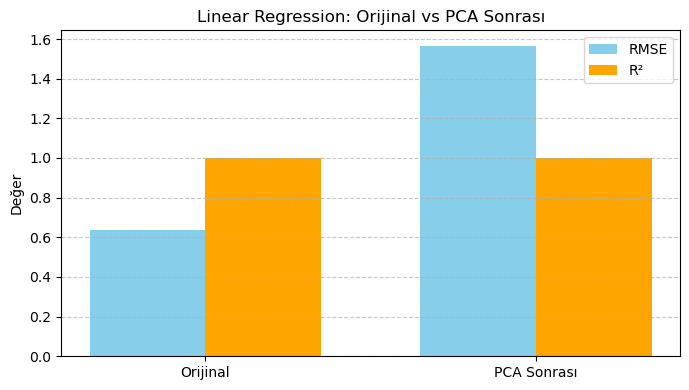

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Modeller / Durumlar
modeller = ['Orijinal', 'PCA Sonrası']

# Ölçüt değerleri
rmse_degerleri = [rmse, rmse_pca]   # RMSE öncesi ve sonrası PCA
r2_degerleri = [r2, r2_pca]         # R² öncesi ve sonrası PCA

x = np.arange(len(modeller))  # x eksenindeki konumlar
genislik = 0.35  # sütun genişliği

plt.figure(figsize=(7,4))

# Sütun grafiği çizimi
plt.bar(x - genislik/2, rmse_degerleri, genislik, label='RMSE', color='skyblue')
plt.bar(x + genislik/2, r2_degerleri, genislik, label='R²', color='orange')

# Etiketler
plt.ylabel('Değer')
plt.title('Linear Regression: Orijinal vs PCA Sonrası')
plt.xticks(x, modeller)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

#  XGBoost modeli
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_selected, y_train)

#  Tahmin
y_pred_xgb = xgb_model.predict(X_test_selected)

# Ölçümleri hesapla
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)




In [17]:
# Sonuçları göster
print("\n XGBoost Regression sonuçlar:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")


 XGBoost Regression sonuçlar:
RMSE: 146.81
R²: 0.4886


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# XGBoost tüm özelliklerle (orijinal)
xgb_model_all = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_all.fit(X_train_scaled, y_train)
y_pred_all = xgb_model_all.predict(X_test_scaled)

mae_all = mean_absolute_error(y_test, y_pred_all)
mse_all = mean_squared_error(y_test, y_pred_all)
rmse_all = np.sqrt(mse_all)
r2_all = r2_score(y_test, y_pred_all)

# XGBoost Feature Selection sonrası
xgb_model_sel = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_sel.fit(X_train_selected, y_train)
y_pred_sel = xgb_model_sel.predict(X_test_selected)

mae_sel = mean_absolute_error(y_test, y_pred_sel)
mse_sel = mean_squared_error(y_test, y_pred_sel)
rmse_sel = np.sqrt(mse_sel)
r2_sel = r2_score(y_test, y_pred_sel)



In [19]:

# Sonuçları göster (Feature Selection sonrası)
print("\n XGBoost Regression (Feature Selection sonrası):")
print(f"RMSE: {rmse_sel:.2f}")
print(f"R²: {r2_sel:.4f}")


 XGBoost Regression (Feature Selection sonrası):
RMSE: 146.81
R²: 0.4886


In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# PCA ile veriler üzerinde XGBoost eğitimi
xgb_pca = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_pca.fit(X_train_pca, y_train)

#  Test verisi üzerinde tahmin
y_pred_xgb_pca = xgb_pca.predict(X_test_pca)

#  Performans metriklerini hesaplama
mae_xgb_pca = mean_absolute_error(y_test, y_pred_xgb_pca)
mse_xgb_pca = mean_squared_error(y_test, y_pred_xgb_pca)
rmse_xgb_pca = np.sqrt(mse_xgb_pca)
r2_xgb_pca = r2_score(y_test, y_pred_xgb_pca)



In [21]:

#  Sonuçları gösterme
print("\n XGBoost(PCA sonrası):")
print(f"RMSE: {rmse_xgb_pca:.2f}")
print(f"R²: {r2_xgb_pca:.4f}")


 XGBoost(PCA sonrası):
RMSE: 147.40
R²: 0.4845


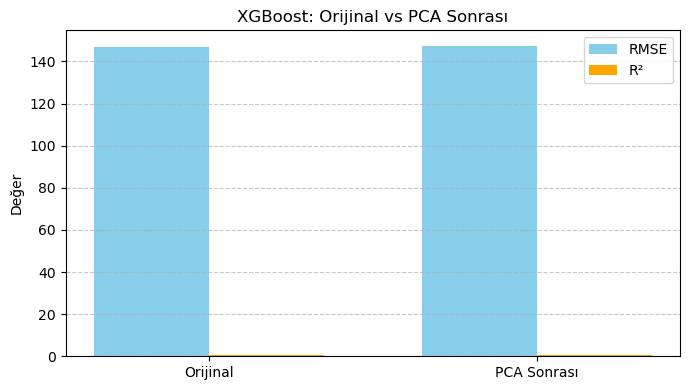

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Modeller / Durumlar
modeller = ['Orijinal', 'PCA Sonrası']

# Ölçüt değerleri
rmse_degerleri = [rmse_xgb, rmse_xgb_pca]   # RMSE öncesi ve sonrası PCA
r2_degerleri = [r2_xgb, r2_xgb_pca]         # R² öncesi ve sonrası PCA

x = np.arange(len(modeller))  # x eksenindeki konumlar
genislik = 0.35  # sütun genişliği

plt.figure(figsize=(7,4))

# Sütun grafiği çizimi
plt.bar(x - genislik/2, rmse_degerleri, genislik, label='RMSE', color='skyblue')
plt.bar(x + genislik/2, r2_degerleri, genislik, label='R²', color='orange')

# Etiketler
plt.ylabel('Değer')
plt.title('XGBoost: Orijinal vs PCA Sonrası')
plt.xticks(x, modeller)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


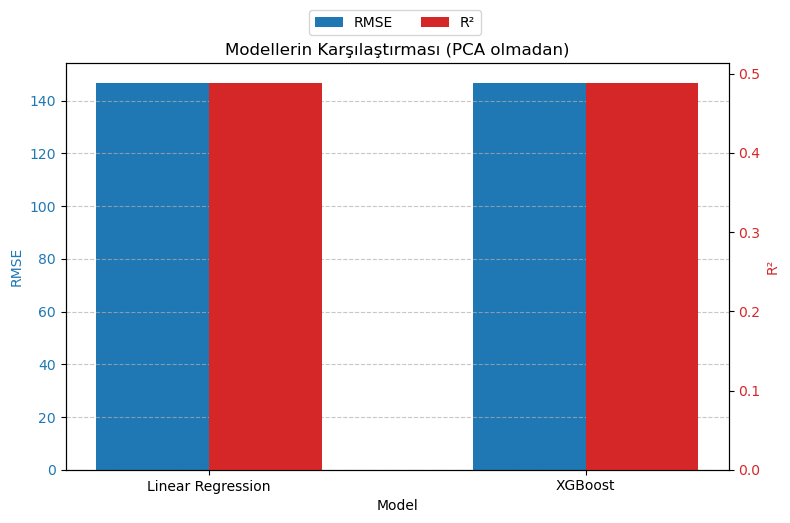

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE ve R² değerleri (PCA olmadan)
modeller = ['Linear Regression', 'XGBoost']
rmse_degerleri = [rmse_sel, rmse_xgb]  # Feature Selection sonrası hesaplanan değerler
r2_degerleri = [r2_sel, r2_xgb]        # Feature Selection sonrası hesaplanan değerler

x = np.arange(len(modeller))

fig, ax1 = plt.subplots(figsize=(8,5))

# RMSE birinci eksende
renk = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=renk)
ax1.bar(x - 0.15, rmse_degerleri, width=0.3, color=renk, label='RMSE')
ax1.tick_params(axis='y', labelcolor=renk)
ax1.set_xticks(x)
ax1.set_xticklabels(modeller)

# R² ikinci eksende
ax2 = ax1.twinx()
renk = 'tab:red'
ax2.set_ylabel('R²', color=renk)
ax2.bar(x + 0.15, r2_degerleri, width=0.3, color=renk, label='R²')
ax2.tick_params(axis='y', labelcolor=renk)

# Başlık ve grid
plt.title('Modellerin Karşılaştırması (PCA olmadan)')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.show()
